## Preprocessing nuclei segmentation training datasets for U-Net

First let's load all of the python packages that we will need.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import morphology as morph
import scipy as sp
from scipy import ndimage
from skimage import feature
from skimage import exposure, io
from skimage.io import imread, imsave
from utils import get_image
import glob, os, fnmatch

Using TensorFlow backend.


We define the directories where the images and classes are located. We define both training and validation datasets.

In [2]:
# Confocal training dataset
direc_name = './trainingData/nucleiSegmentation/'
# training dataset
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CFtraining_Unet.npz')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image4","E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2","E2F8_EdU_mouse1_image2","E2F8_pH3_mouse1_image2"]

channel_names = ["nuclear"]

We define the parameteres for preprocessing.

In [3]:
# window size for local average subtraction
normalizing_window_size_x = 32
normalizing_window_size_y = 32
# number of classes
nb_classes = 3
# parameter used to dilate one class (here the nuclei contours)
is_edge_class = [1,0,0]
# structuring element size for dilation
dil_radius = 1

We load the images and initialize the variables.

In [4]:
nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

We preprocess the images and classes: <br>
    1) the intensity in the images is dividied by themedian intensity <br>
    2) a local average subtraction is applied <br>
    3) a dilation is applied to the nuclei contours

In [5]:
# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    

We plot the images and classes to make sure everything went well.

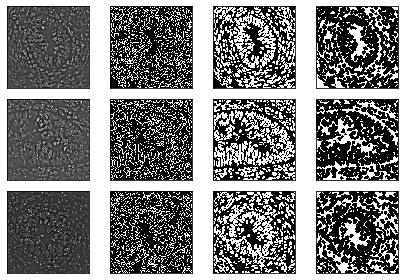

In [6]:
nb_training_examples = 3#len(training_direcs)
fig,ax = plt.subplots(nb_training_examples,nb_classes+1, squeeze = False)
for j in range(nb_training_examples):
	ax[j,0].imshow(channels[j,:,:,0],cmap=plt.cm.gray,interpolation='nearest')
	def form_coord(x,y):
		return cf(x,y,channels[j,0,:,:])
	ax[j,0].format_coord = form_coord
	ax[j,0].axes.get_xaxis().set_visible(False)
	ax[j,0].axes.get_yaxis().set_visible(False)

	for k in range(1,nb_classes+1):
		ax[j,k].imshow(class_mask[j,:,:,k-1],cmap=plt.cm.gray,interpolation='nearest')
		def form_coord(x,y):
			return cf(x,y,class_mask[j,:,:,k-1])
		ax[j,k].format_coord = form_coord
		ax[j,k].axes.get_xaxis().set_visible(False)
		ax[j,k].axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

We save the preprocessed training dataset.

In [8]:
np.savez(file_name_save, channels = channels, y = class_mask)

We do the same for confocal validation dataset...

In [9]:
# Confocal validation set
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CFvalidation_Unet.npz')
training_direcs = ["E2F3A_EdU_mouse1_image2","E2F3A_pH3_mouse1_image3","E2F8_EdU_mouse1_image1"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 0
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,0] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

np.savez(file_name_save, channels = channels, y = class_mask)

 ... for the wide-field training dataset...

In [10]:
# WideField training dataset
direc_name = './trainingData/nucleiSegmentation/'
# training dataset
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_WFtraining_Unet.npz')
training_direcs = ["E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse2_image3","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 0
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,0] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

np.savez(file_name_save, channels = channels, y = class_mask)

 ... for the wide-field validation dataset...

In [11]:
# WideField validation dataset
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_WFvalidation_Unet.npz')
training_direcs = ["E2F3A_E2F4_mouse1_image3","E2F3A_E2F4_mouse2_image3","E2F3A_E2F8_mouse3_image3","E2F3A_EdU_mouse2_image3","E2F3A_pH3_mouse3_image3","E2F4_pH3_mouse1_image3","E2F8_EdU_mouse2_image3","E2F8_pH3_mouse3_image3"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 0
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,0] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

np.savez(file_name_save, channels = channels, y = class_mask)

 ... for the confocal and wide-field training dataset...

In [ ]:
# Confocal - WideField training dataset
direc_name = './trainingData/nucleiSegmentation/'
# training dataset
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CFWFtraining_Unet.npz')
training_direcs = ["E2F3A_E2F8_mouse1_image1","E2F3A_E2F8_mouse1_image2","E2F3A_E2F8_mouse1_image3","E2F3A_EdU_mouse1_image1","E2F3A_EdU_mouse1_image4","E2F3A_pH3_mouse1_image1","E2F3A_pH3_mouse1_image2","E2F8_EdU_mouse1_image2","E2F8_pH3_mouse1_image2","E2F3A_E2F4_mouse1_image1","E2F3A_E2F4_mouse1_image2","E2F3A_E2F4_mouse2_image1","E2F3A_E2F4_mouse2_image2","E2F3A_E2F8_mouse2_image1","E2F3A_E2F8_mouse2_image2","E2F3A_E2F8_mouse3_image1","E2F3A_E2F8_mouse3_image2","E2F3A_EdU_mouse2_image1","E2F3A_EdU_mouse2_image2","E2F3A_EdU_mouse3_image1","E2F3A_EdU_mouse3_image2","E2F3A_pH3_mouse2_image1","E2F3A_pH3_mouse2_image2","E2F3A_pH3_mouse2_image3","E2F3A_pH3_mouse3_image1","E2F3A_pH3_mouse3_image2","E2F4_EdU_mouse1_image1","E2F4_EdU_mouse1_image2","E2F4_EdU_mouse1_image3","E2F4_EdU_mouse2_image1","E2F4_EdU_mouse2_image2","E2F4_pH3_mouse1_image1","E2F4_pH3_mouse1_image2","E2F4_pH3_mouse2_image1","E2F4_pH3_mouse2_image2","E2F4_pH3_mouse2_image3","E2F8_EdU_mouse2_image1","E2F8_EdU_mouse2_image2","E2F8_EdU_mouse3_image1","E2F8_EdU_mouse3_image2","E2F8_EdU_mouse3_image3","E2F8_pH3_mouse2_image1","E2F8_pH3_mouse2_image2","E2F8_pH3_mouse2_image3","E2F8_pH3_mouse3_image1","E2F8_pH3_mouse3_image2"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 0
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,0] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

np.savez(file_name_save, channels = channels, y = class_mask)

 ... and for the confocal and wide-field validation dataset.

In [ ]:
# Confocal - WideField validation dataset
file_name_save = os.path.join('./trainingDataNpz/nucleiSegmentation/', 'nuclei_CFWFvalidation_Unet.npz')
training_direcs = ["E2F3A_EdU_mouse1_image2","E2F3A_pH3_mouse1_image3","E2F8_EdU_mouse1_image1","E2F3A_E2F4_mouse1_image3","E2F3A_E2F4_mouse2_image3","E2F3A_E2F8_mouse3_image3","E2F3A_EdU_mouse2_image3","E2F3A_pH3_mouse3_image3","E2F4_pH3_mouse1_image3","E2F8_EdU_mouse2_image3","E2F8_pH3_mouse3_image3"]

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variable for images
imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

# Load training images
direc_counter = 0
for direc in training_direcs:
	imglist = os.listdir(os.path.join(direc_name, direc))
	channel_counter = 0

	# Load channels
	for channel in channel_names:
		for img in imglist: 
			if fnmatch.fnmatch(img, r'*' + channel + r'*'):
				channel_file = img
				channel_file = os.path.join(direc_name, direc, channel_file)
				channel_img = get_image(channel_file)
    
                # Normalize the images
				p50 = np.percentile(channel_img, 50)
				channel_img /= max(p50,0.01)

				avg_kernel = np.ones((normalizing_window_size_x, normalizing_window_size_y))
				channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size

				channels[direc_counter, :, :, channel_counter] = channel_img
				channel_counter += 1

	# Load class mask
	for j in range(nb_classes):
		class_name = "feature_" + str(j) + r".*"
		for img in imglist:
			if fnmatch.fnmatch(img, class_name):
				class_file = os.path.join(direc_name, direc, img)
				class_img = get_image(class_file)

				if np.sum(class_img) > 0:
					class_img /= np.amax(class_img)

				if is_edge_class[j] == 1:
					strel = sk.morphology.disk(dil_radius)
					class_img = sk.morphology.binary_dilation(class_img, selem = strel)

				class_mask[direc_counter, :, :, j] = class_img
    
	# Update class regions wrt to dilation
	for j in range(nb_classes):
		if is_edge_class[j] != 1:
			for k in range(nb_classes):
				if is_edge_class[k] == 1:
					class_mask[direc_counter, :, :, j] -= class_mask[direc_counter, :, :, k]
			class_mask[direc_counter, :, :, j] = class_mask[direc_counter, :, :, j] > 0
            
	direc_counter += 1
    
# id (rank) for image and classes in the training dataset we want to save
imageId = 0
# input image
NormalizedImage = np.zeros((image_size_x, image_size_y), dtype='float32')
NormalizedImage = channels[imageId,:,:,0] 
imgToSave_name = os.path.join("./", "normalizedImage.tif")
io.imsave(imgToSave_name,NormalizedImage)
# first class
class0 = np.zeros((image_size_x, image_size_y), dtype='float32')
class0 = class_mask[imageId,:,:,0]*255.
class0 = class0.astype(np.uint8)
imgToSave_name = os.path.join("./", "class0.png")
imsave(imgToSave_name,class0)
# second class
class1 = np.zeros((image_size_x, image_size_y), dtype='float32')
class1 = class_mask[imageId,:,:,1]*255.
class1 = class1.astype(np.uint8)
imgToSave_name = os.path.join("./", "class1.png")
imsave(imgToSave_name,class1)
# third class
class2 = np.zeros((image_size_x, image_size_y), dtype='float32')
class2 = class_mask[imageId,:,:,2]*255.
class2 = class2.astype(np.uint8)
imgToSave_name = os.path.join("./", "class2.png")
imsave(imgToSave_name,class2)

np.savez(file_name_save, channels = channels, y = class_mask)